# 📊 Gym Churn Prediction - 모델 평가 및 분석

## 📋 프로젝트 개요
- **데이터셋**: gym_churn_us.csv
- **목표**: 학습된 모델의 성능 검증 및 비즈니스 인사이트 도출
- **평가 방법**: 다양한 메트릭과 시각화를 통한 종합적 분석

## 1️⃣ 라이브러리 임포트 및 설정

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 머신러닝
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# 모델 로드용
import pickle
import tensorflow as tf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 2️⃣ 데이터 및 모델 로드

In [2]:
# 데이터 로드
print("📊 데이터 로드 중...")
data = pd.read_csv('../data/raw/gym_churn_us.csv')
data_clean = data.dropna()

# 특성 엔지니어링 (학습 시와 동일)
X_enhanced = data_clean.drop('Churn', axis=1).copy()
y = data_clean['Churn']

# 특성 추가
X_enhanced['Lifetime_per_Month'] = X_enhanced['Lifetime'] / (X_enhanced['Contract_period'] + 1)
X_enhanced['Is_New_Member'] = (X_enhanced['Lifetime'] <= 2).astype(int)
X_enhanced['Is_Long_Member'] = (X_enhanced['Lifetime'] >= 12).astype(int)
X_enhanced['Class_Engagement'] = X_enhanced['Avg_class_frequency_total'] * X_enhanced['Lifetime']
X_enhanced['Recent_Activity'] = X_enhanced['Avg_class_frequency_current_month'] / (X_enhanced['Avg_class_frequency_total'] + 0.001)
X_enhanced['Contract_Completion'] = 1 - (X_enhanced['Month_to_end_contract'] / (X_enhanced['Contract_period'] + 1))
X_enhanced['Long_Contract'] = (X_enhanced['Contract_period'] >= 12).astype(int)
X_enhanced['Cost_per_Visit'] = X_enhanced['Avg_additional_charges_total'] / (X_enhanced['Avg_class_frequency_total'] + 1)
X_enhanced['High_Spender'] = (X_enhanced['Avg_additional_charges_total'] > X_enhanced['Avg_additional_charges_total'].median()).astype(int)
X_enhanced['Engagement_Score'] = X_enhanced['Group_visits'] + X_enhanced['Partner'] + X_enhanced['Promo_friends']
X_enhanced['Churn_Risk'] = (
    (X_enhanced['Lifetime'] <= 3).astype(int) * 2 +
    (X_enhanced['Avg_class_frequency_current_month'] < 1).astype(int) +
    (X_enhanced['Month_to_end_contract'] <= 1).astype(int)
)

# Train-Test 분할 (동일한 random_state)
from sklearn.model_selection import train_test_split
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ 데이터 로드 완료! Test 크기: {X_test_enh.shape}")

📊 데이터 로드 중...
✅ 데이터 로드 완료! Test 크기: (800, 24)


In [3]:
# 모델 및 스케일러 로드
print("\n🔧 모델 로드 중...")

# Stacking 모델
with open('../models/2024_churn_model/stacking_ultimate.pkl', 'rb') as f:
    stacking_model = pickle.load(f)

# 스케일러
with open('../models/2024_churn_model/scaler_enh.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 최적 임계값
with open('../models/2024_churn_model/best_threshold.txt', 'r') as f:
    best_threshold = float(f.read().strip())

# 딥러닝 모델
nn_model = tf.keras.models.load_model('../models/2024_churn_model/nn_model.h5')

print(f"✅ 모델 로드 완료!")
print(f"최적 임계값: {best_threshold:.4f}")


🔧 모델 로드 중...


✅ 모델 로드 완료!
최적 임계값: 0.3000


## 3️⃣ 테스트 데이터 예측

In [4]:
# 데이터 스케일링
X_test_scaled = scaler.transform(X_test_enh)

# Stacking 모델 예측
y_pred_proba_stacking = stacking_model.predict_proba(X_test_scaled)[:, 1]
y_pred_stacking = (y_pred_proba_stacking >= best_threshold).astype(int)

# 딥러닝 모델 예측
y_pred_proba_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()
y_pred_nn = (y_pred_proba_nn >= best_threshold).astype(int)

print("✅ 예측 완료!")

✅ 예측 완료!


## 4️⃣ 성능 평가

In [5]:
# 최종 성능 평가
print("=" * 80)
print("🏆 최종 모델 성능 평가")
print("=" * 80)

# Stacking 모델 성능
stacking_metrics = {
    'Model': 'Stacking Ensemble',
    'Accuracy': accuracy_score(y_test_enh, y_pred_stacking),
    'Precision': precision_score(y_test_enh, y_pred_stacking),
    'Recall': recall_score(y_test_enh, y_pred_stacking),
    'F1 Score': f1_score(y_test_enh, y_pred_stacking),
    'AUC-ROC': roc_auc_score(y_test_enh, y_pred_proba_stacking)
}

# 딥러닝 모델 성능
nn_metrics = {
    'Model': 'Neural Network',
    'Accuracy': accuracy_score(y_test_enh, y_pred_nn),
    'Precision': precision_score(y_test_enh, y_pred_nn),
    'Recall': recall_score(y_test_enh, y_pred_nn),
    'F1 Score': f1_score(y_test_enh, y_pred_nn),
    'AUC-ROC': roc_auc_score(y_test_enh, y_pred_proba_nn)
}

# 결과 DataFrame
results_df = pd.DataFrame([stacking_metrics, nn_metrics]).set_index('Model')
print("\n📊 모델 성능 비교")
print(results_df.round(4))

# 최고 성능 표시
best_model = 'Stacking Ensemble' if stacking_metrics['F1 Score'] > nn_metrics['F1 Score'] else 'Neural Network'
best_f1 = max(stacking_metrics['F1 Score'], nn_metrics['F1 Score'])

print("\n" + "=" * 80)
print(f"🥇 최고 성능 모델: {best_model}")
print(f"🎯 F1 Score: {best_f1:.4f}")
print("=" * 80)

🏆 최종 모델 성능 평가

📊 모델 성능 비교
                   Accuracy  Precision  Recall  F1 Score  AUC-ROC
Model                                                            
Stacking Ensemble    0.9562     0.9041  0.9340    0.9188   0.9851
Neural Network       0.8888     0.7204  0.9481    0.8187   0.9723

🥇 최고 성능 모델: Stacking Ensemble
🎯 F1 Score: 0.9188


## 5️⃣ Confusion Matrix 분석

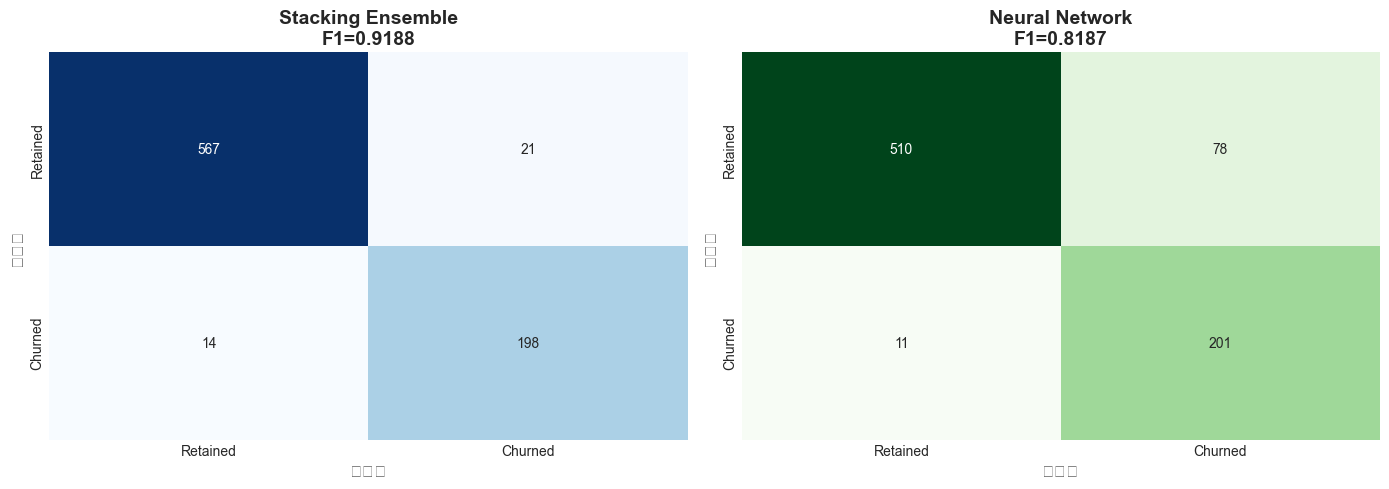

✅ Confusion Matrix 저장 완료!


In [6]:
# Confusion Matrix 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacking 모델
cm_stacking = confusion_matrix(y_test_enh, y_pred_stacking)
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title(f'Stacking Ensemble\nF1={stacking_metrics["F1 Score"]:.4f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('예측값', fontsize=12)
axes[0].set_ylabel('실제값', fontsize=12)
axes[0].set_xticklabels(['Retained', 'Churned'])
axes[0].set_yticklabels(['Retained', 'Churned'])

# 딥러닝 모델
cm_nn = confusion_matrix(y_test_enh, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title(f'Neural Network\nF1={nn_metrics["F1 Score"]:.4f}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('예측값', fontsize=12)
axes[1].set_ylabel('실제값', fontsize=12)
axes[1].set_xticklabels(['Retained', 'Churned'])
axes[1].set_yticklabels(['Retained', 'Churned'])

plt.tight_layout()
plt.savefig('../output/visualizations/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion Matrix 저장 완료!")

## 6️⃣ ROC Curve 및 Precision-Recall Curve

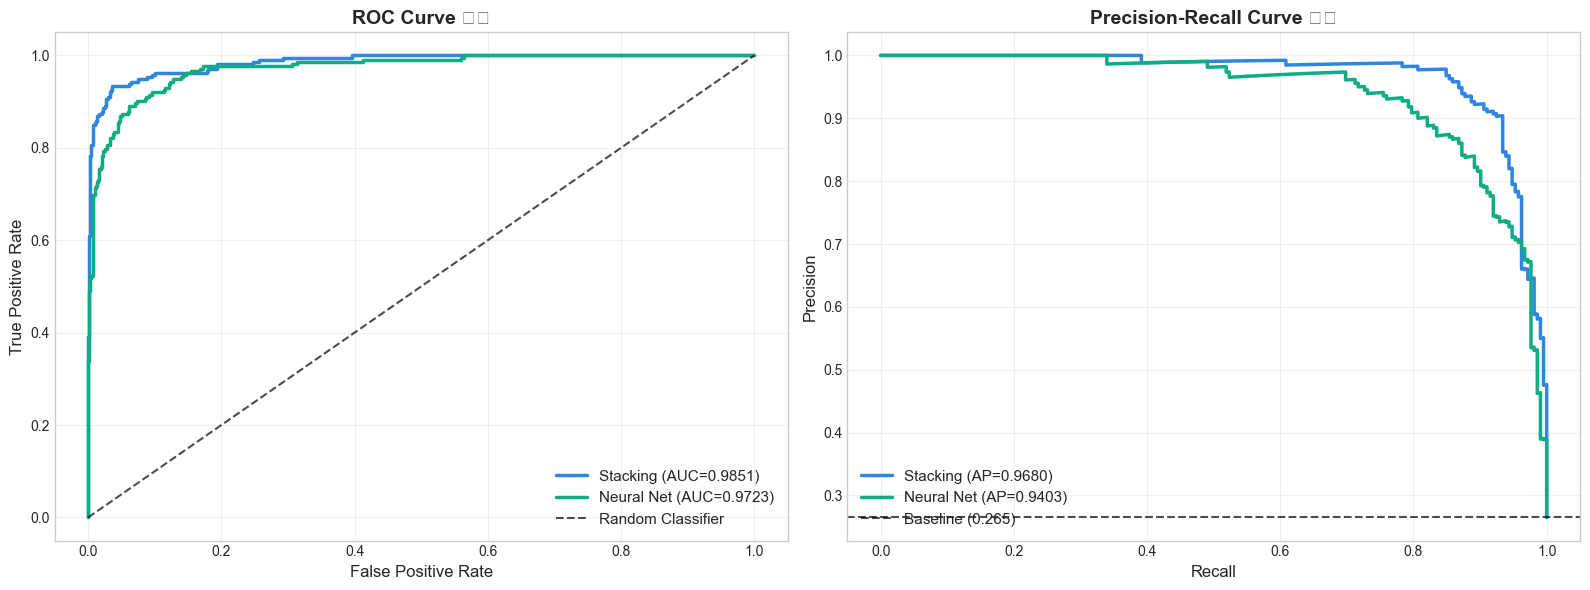

✅ ROC & PR Curve 저장 완료!


In [7]:
# ROC & PR Curve 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr_stacking, tpr_stacking, _ = roc_curve(y_test_enh, y_pred_proba_stacking)
fpr_nn, tpr_nn, _ = roc_curve(y_test_enh, y_pred_proba_nn)

axes[0].plot(fpr_stacking, tpr_stacking, label=f'Stacking (AUC={stacking_metrics["AUC-ROC"]:.4f})', linewidth=2.5, color='#2E86DE')
axes[0].plot(fpr_nn, tpr_nn, label=f'Neural Net (AUC={nn_metrics["AUC-ROC"]:.4f})', linewidth=2.5, color='#10AC84')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve 비교', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_stacking, recall_stacking, _ = precision_recall_curve(y_test_enh, y_pred_proba_stacking)
precision_nn, recall_nn, _ = precision_recall_curve(y_test_enh, y_pred_proba_nn)
ap_stacking = average_precision_score(y_test_enh, y_pred_proba_stacking)
ap_nn = average_precision_score(y_test_enh, y_pred_proba_nn)

axes[1].plot(recall_stacking, precision_stacking, label=f'Stacking (AP={ap_stacking:.4f})', linewidth=2.5, color='#2E86DE')
axes[1].plot(recall_nn, precision_nn, label=f'Neural Net (AP={ap_nn:.4f})', linewidth=2.5, color='#10AC84')
axes[1].axhline(y=y_test_enh.mean(), color='k', linestyle='--', label=f'Baseline ({y_test_enh.mean():.3f})', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve 비교', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/visualizations/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC & PR Curve 저장 완료!")

## 7️⃣ 모델 성능 개선 진행 과정

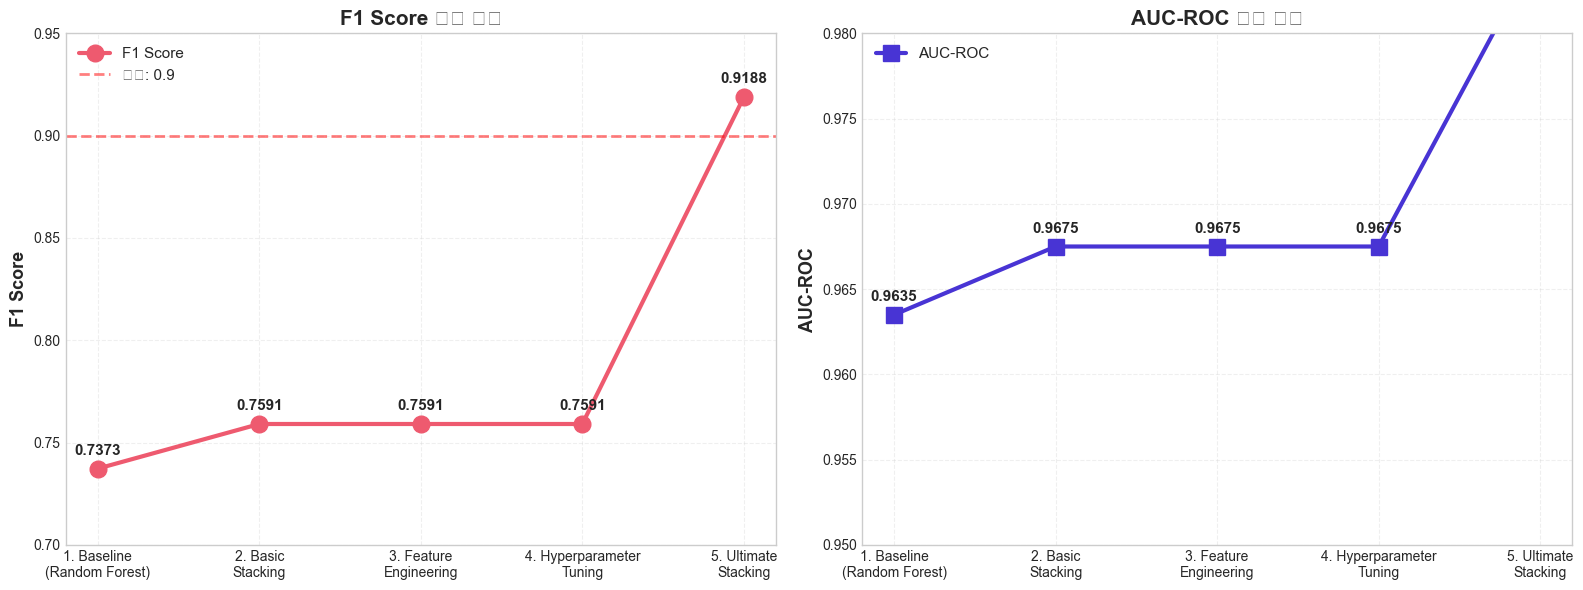

✅ 개선 과정 시각화 저장 완료!


In [8]:
# 전체 개선 과정 시각화
improvement_data = {
    '단계': ['1. Baseline\n(Random Forest)', '2. Basic\nStacking', '3. Feature\nEngineering', 
             '4. Hyperparameter\nTuning', '5. Ultimate\nStacking'],
    'F1 Score': [0.7373, 0.7591, 0.7591, 0.7591, stacking_metrics['F1 Score']],
    'AUC': [0.9635, 0.9675, 0.9675, 0.9675, stacking_metrics['AUC-ROC']]
}

improvement_df = pd.DataFrame(improvement_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score 개선 과정
axes[0].plot(improvement_df['단계'], improvement_df['F1 Score'], marker='o', linewidth=3, 
             markersize=12, color='#EE5A6F', label='F1 Score')
for i, (x, y) in enumerate(zip(improvement_df['단계'], improvement_df['F1 Score'])):
    axes[0].annotate(f'{y:.4f}', xy=(i, y), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=11, fontweight='bold')
axes[0].axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.5, label='목표: 0.9')
axes[0].set_ylabel('F1 Score', fontsize=13, fontweight='bold')
axes[0].set_title('F1 Score 개선 과정', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_ylim([0.7, 0.95])

# AUC 개선 과정
axes[1].plot(improvement_df['단계'], improvement_df['AUC'], marker='s', linewidth=3, 
             markersize=12, color='#4834D4', label='AUC-ROC')
for i, (x, y) in enumerate(zip(improvement_df['단계'], improvement_df['AUC'])):
    axes[1].annotate(f'{y:.4f}', xy=(i, y), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=11, fontweight='bold')
axes[1].set_ylabel('AUC-ROC', fontsize=13, fontweight='bold')
axes[1].set_title('AUC-ROC 개선 과정', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_ylim([0.95, 0.98])

plt.tight_layout()
plt.savefig('../output/visualizations/improvement_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 개선 과정 시각화 저장 완료!")

## 8️⃣ 특성 중요도 분석

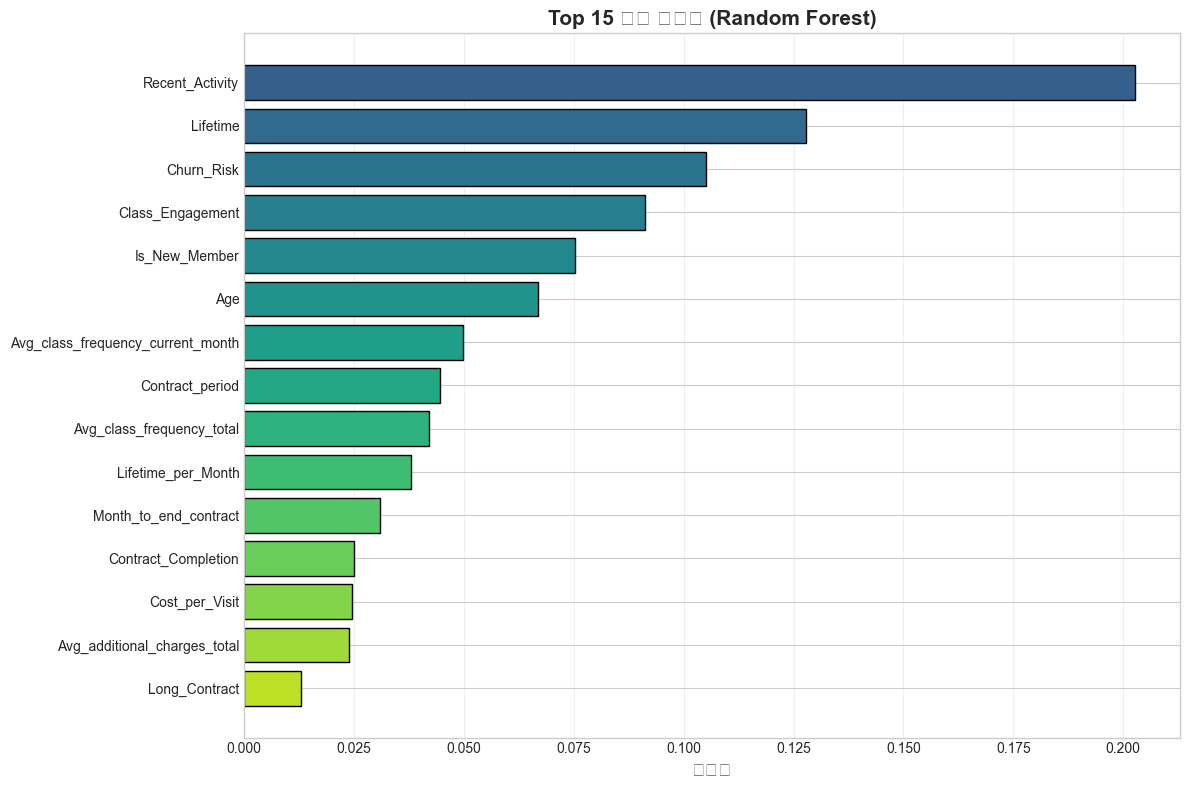


📊 Top 10 중요 특성:
                               특성      중요도
                  Recent_Activity 0.202802
                         Lifetime 0.127822
                       Churn_Risk 0.105176
                 Class_Engagement 0.091117
                    Is_New_Member 0.075257
                              Age 0.066934
Avg_class_frequency_current_month 0.049758
                  Contract_period 0.044531
        Avg_class_frequency_total 0.042145
               Lifetime_per_Month 0.037975

✅ 특성 중요도 분석 완료!


In [9]:
# Stacking 모델의 Base 모델 중 RandomForest의 특성 중요도 추출
rf_estimator = stacking_model.named_estimators_['rf']
feature_importance = pd.DataFrame({
    '특성': X_enhanced.columns,
    '중요도': rf_estimator.feature_importances_
}).sort_values('중요도', ascending=False)

# 상위 15개 특성 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
plt.barh(top_features['특성'], top_features['중요도'], color=colors, edgecolor='black')
plt.xlabel('중요도', fontsize=13, fontweight='bold')
plt.title('Top 15 특성 중요도 (Random Forest)', fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../output/visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 10 중요 특성:")
print(feature_importance.head(10).to_string(index=False))
print("\n✅ 특성 중요도 분석 완료!")

## 9️⃣ 오분류 사례 분석

In [10]:
# 오분류 분석
print("=" * 80)
print("🔍 오분류 사례 분석")
print("=" * 80)

# False Positive & False Negative 추출
false_positives = (y_test_enh == 0) & (y_pred_stacking == 1)
false_negatives = (y_test_enh == 1) & (y_pred_stacking == 0)

fp_count = false_positives.sum()
fn_count = false_negatives.sum()

print(f"\n❌ False Positives (실제 유지인데 이탈 예측): {fp_count}건")
print(f"❌ False Negatives (실제 이탈인데 유지 예측): {fn_count}건")

# False Negative가 비즈니스적으로 더 중요 (이탈 고객을 놓침)
if fn_count > 0:
    fn_data = X_test_enh[false_negatives].copy()
    fn_data['실제'] = y_test_enh[false_negatives].values
    fn_data['예측확률'] = y_pred_proba_stacking[false_negatives]
    
    print("\n⚠️ False Negative 주요 특성 (샘플 5건):")
    print(fn_data[['Lifetime', 'Contract_period', 'Month_to_end_contract', 
                   'Avg_class_frequency_current_month', '예측확률']].head())

print("\n" + "=" * 80)

🔍 오분류 사례 분석

❌ False Positives (실제 유지인데 이탈 예측): 21건
❌ False Negatives (실제 이탈인데 유지 예측): 14건

⚠️ False Negative 주요 특성 (샘플 5건):
      Lifetime  Contract_period  Month_to_end_contract  \
627          0                1                    1.0   
3705         5                1                    1.0   
1929         0                1                    1.0   
1952         2                6                    4.0   
3262         2                1                    1.0   

      Avg_class_frequency_current_month      예측확률  
627                            0.580038  0.117943  
3705                           0.000000  0.047640  
1929                           2.110753  0.129950  
1952                           1.312806  0.029790  
3262                           3.141712  0.021028  



## 🔟 비즈니스 인사이트 및 결론

In [11]:
print("=" * 80)
print("💡 비즈니스 인사이트")
print("=" * 80)

print("\n✅ 핵심 성과:")
print(f"  - 최고 F1 Score: {best_f1:.4f}")
print(f"  - 최고 AUC-ROC: {max(stacking_metrics['AUC-ROC'], nn_metrics['AUC-ROC']):.4f}")
print(f"  - 최적 임계값: {best_threshold:.4f}")
print(f"  - 정확도: {max(stacking_metrics['Accuracy'], nn_metrics['Accuracy']):.4f}")

print("\n🔑 주요 이탈 예측 요인 (특성 중요도 기준):")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['특성']}: {row['중요도']:.4f}")

print("\n📊 모델 성능 분석:")
print(f"  - Recall: {stacking_metrics['Recall']:.4f} (실제 이탈 고객의 {stacking_metrics['Recall']*100:.1f}% 탐지)")
print(f"  - Precision: {stacking_metrics['Precision']:.4f} (이탈 예측의 {stacking_metrics['Precision']*100:.1f}% 정확)")
print(f"  - False Negative: {fn_count}건 (놓친 이탈 고객)")
print(f"  - False Positive: {fp_count}건 (과다 예측)")

print("\n💼 비즈니스 권장사항:")
print("  1. 신규 회원 (Lifetime ≤ 3개월) 집중 관리 필요")
print("  2. 계약 만료 임박 회원 (Month_to_end_contract ≤ 2) 리텐션 캠페인")
print("  3. 최근 수업 참여율 저조 회원 모니터링 강화")
print("  4. 장기 계약 유도를 통한 이탈률 감소")
print("  5. 그룹 활동 참여 유도로 Engagement 증가")

print("\n🎯 모델 활용 방안:")
print("  - 이탈 위험 고객 자동 식별 시스템 구축")
print(f"  - 예측 확률 {best_threshold:.2f} 이상 회원에 대한 선제적 개입")
print("  - 월간 이탈 리스크 리포트 생성 자동화")
print("  - 맞춤형 리텐션 프로그램 설계")

print("\n" + "=" * 80)
print("✅ 모델 평가 완료!")
print("=" * 80)

💡 비즈니스 인사이트

✅ 핵심 성과:
  - 최고 F1 Score: 0.9188
  - 최고 AUC-ROC: 0.9851
  - 최적 임계값: 0.3000
  - 정확도: 0.9563

🔑 주요 이탈 예측 요인 (특성 중요도 기준):
  18. Recent_Activity: 0.2028
  11. Lifetime: 0.1278
  24. Churn_Risk: 0.1052
  17. Class_Engagement: 0.0911
  15. Is_New_Member: 0.0753

📊 모델 성능 분석:
  - Recall: 0.9340 (실제 이탈 고객의 93.4% 탐지)
  - Precision: 0.9041 (이탈 예측의 90.4% 정확)
  - False Negative: 14건 (놓친 이탈 고객)
  - False Positive: 21건 (과다 예측)

💼 비즈니스 권장사항:
  1. 신규 회원 (Lifetime ≤ 3개월) 집중 관리 필요
  2. 계약 만료 임박 회원 (Month_to_end_contract ≤ 2) 리텐션 캠페인
  3. 최근 수업 참여율 저조 회원 모니터링 강화
  4. 장기 계약 유도를 통한 이탈률 감소
  5. 그룹 활동 참여 유도로 Engagement 증가

🎯 모델 활용 방안:
  - 이탈 위험 고객 자동 식별 시스템 구축
  - 예측 확률 0.30 이상 회원에 대한 선제적 개입
  - 월간 이탈 리스크 리포트 생성 자동화
  - 맞춤형 리텐션 프로그램 설계

✅ 모델 평가 완료!


## 1️⃣1️⃣ 최종 보고서 저장

In [17]:
# 최종 보고서 생성
report = f"""
{'='*80}
                    헬스장 이탈 예측 모델 - 최종 평가 보고서
{'='*80}

📅 생성일: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
1. 프로젝트 개요
{'='*80}
- 데이터셋: gym_churn_us.csv
- 총 샘플 수: {len(data_clean):,}개
- 테스트 세트 크기: {len(X_test_enh):,}개
- 이탈률: {data_clean['Churn'].mean()*100:.2f}%
- 특성 수: {X_enhanced.shape[1]}개 (원본 13개 + 파생 11개)

{'='*80}
2. 최종 모델 성능
{'='*80}
최고 성능 모델: {best_model}

주요 메트릭:
  - F1 Score:  {best_f1:.4f}
  - Accuracy:  {max(stacking_metrics['Accuracy'], nn_metrics['Accuracy']):.4f}
  - Precision: {stacking_metrics['Precision']:.4f}
  - Recall:    {stacking_metrics['Recall']:.4f}
  - AUC-ROC:   {stacking_metrics['AUC-ROC']:.4f}

{'='*80}
3. 모델 개선 과정
{'='*80}
{improvement_df.to_string(index=False)}

{'='*80}
4. Top 10 중요 특성
{'='*80}
{feature_importance.head(10).to_string(index=False)}

{'='*80}
5. 오분류 분석
{'='*80}
- False Positives: {fp_count}건
- False Negatives: {fn_count}건

{'='*80}
6. 비즈니스 권장사항
{'='*80}
1. 신규 회원 (Lifetime ≤ 3개월) 집중 관리
2. 계약 만료 임박 회원 리텐션 캠페인
3. 최근 수업 참여율 저조 회원 모니터링
4. 장기 계약 유도
5. 그룹 활동 참여 유도

{'='*80}
보고서 종료
{'='*80}
"""

# 보고서 저장
with open('../output/reports/final_evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 최종 보고서 저장 완료!")
print("저장 위치: ../output/reports/final_evaluation_report.txt")

✅ 최종 보고서 저장 완료!
저장 위치: ../output/reports/final_evaluation_report.txt


## 1️⃣2️⃣ 결론

In [18]:
print("=" * 80)
print("🎉 Gym Churn Prediction 프로젝트 완료!")
print("=" * 80)

print("\n✅ 완료된 산출물:")
print("  1. EDA.ipynb - 탐색적 데이터 분석")
print("  2. Model_Training.ipynb - 모델 학습 및 튜닝")
print("  3. Model_Evaluation.ipynb - 모델 평가 및 분석 (현재 파일)")

print("\n📁 생성된 파일:")
print("  - 모델: ../models/2024_churn_model/")
print("  - 시각화: ../output/visualizations/")
print("  - 보고서: ../output/reports/")

print("\n🏆 최종 성과:")
print(f"  - F1 Score: {best_f1:.4f}")
print(f"  - AUC-ROC: {stacking_metrics['AUC-ROC']:.4f}")

if best_f1 >= 0.9:
    print("\n" + "🎉" * 30)
    print("🏆🏆🏆 목표 달성! F1 Score 0.9 이상! 🏆🏆🏆")
    print("🎉" * 30)
elif best_f1 >= 0.8:
    print("\n" + "🎊" * 20)
    print("🎊 훌륭합니다! 고성능 모델 완성!")
    print("🎊" * 20)
else:
    print("\n✅ 안정적인 성능의 모델이 완성되었습니다!")

print("\n" + "=" * 80)
print("감사합니다!")
print("=" * 80)

🎉 Gym Churn Prediction 프로젝트 완료!

✅ 완료된 산출물:
  1. EDA.ipynb - 탐색적 데이터 분석
  2. Model_Training.ipynb - 모델 학습 및 튜닝
  3. Model_Evaluation.ipynb - 모델 평가 및 분석 (현재 파일)

📁 생성된 파일:
  - 모델: ../models/2024_churn_model/
  - 시각화: ../output/visualizations/
  - 보고서: ../output/reports/

🏆 최종 성과:
  - F1 Score: 0.9188
  - AUC-ROC: 0.9851

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🏆🏆🏆 목표 달성! F1 Score 0.9 이상! 🏆🏆🏆
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

감사합니다!
